In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [2]:
df  = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])

In [3]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [4]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

C:\Users\chenk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chenk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [5]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [6]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

C:\Users\chenk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


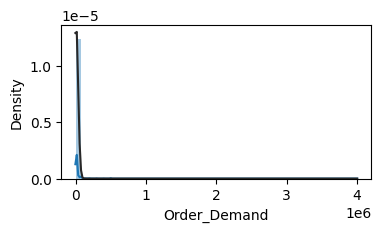

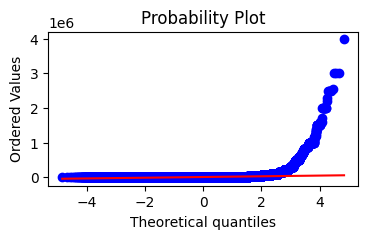

In [7]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [8]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

31.506080242695006

In [9]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [10]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


In [13]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

In [14]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [15]:
#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
y = df['Order_Demand'].resample('MS').mean()

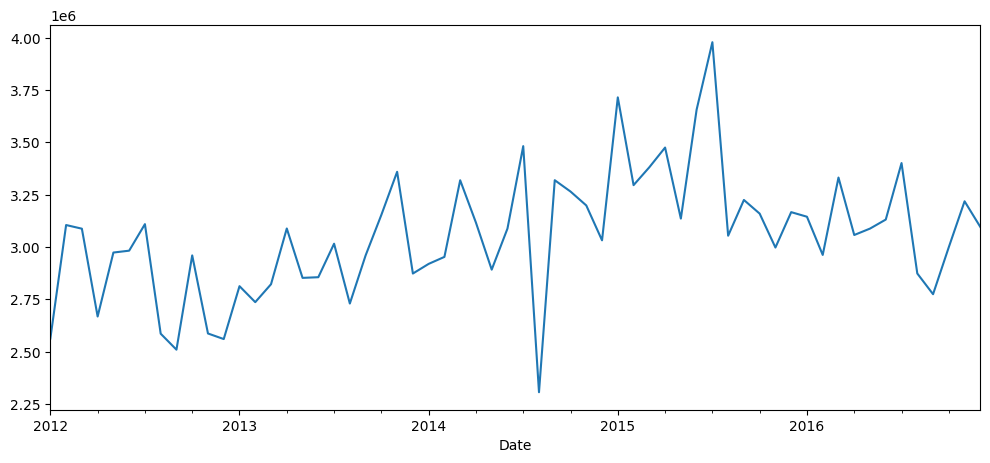

In [16]:
#Visualizing time series.

y.plot(figsize=(12,5))
plt.show()

#Takeaway: The sales are always low for the beginning of the year and the highest peak in demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2014-2016 then reducing.

#Lets check it by decomposition.

In [17]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2975.628859686498
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.845030845773
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859485
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3048.0065240558015
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.0874878045217
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.18380327007
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345484
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2895.7363826322035
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650881
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277816
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759124
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2992.4376007736532
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

In [19]:
#Fit the model with the best params.
#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018646


#The above output suggests that ARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value: 960.516
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


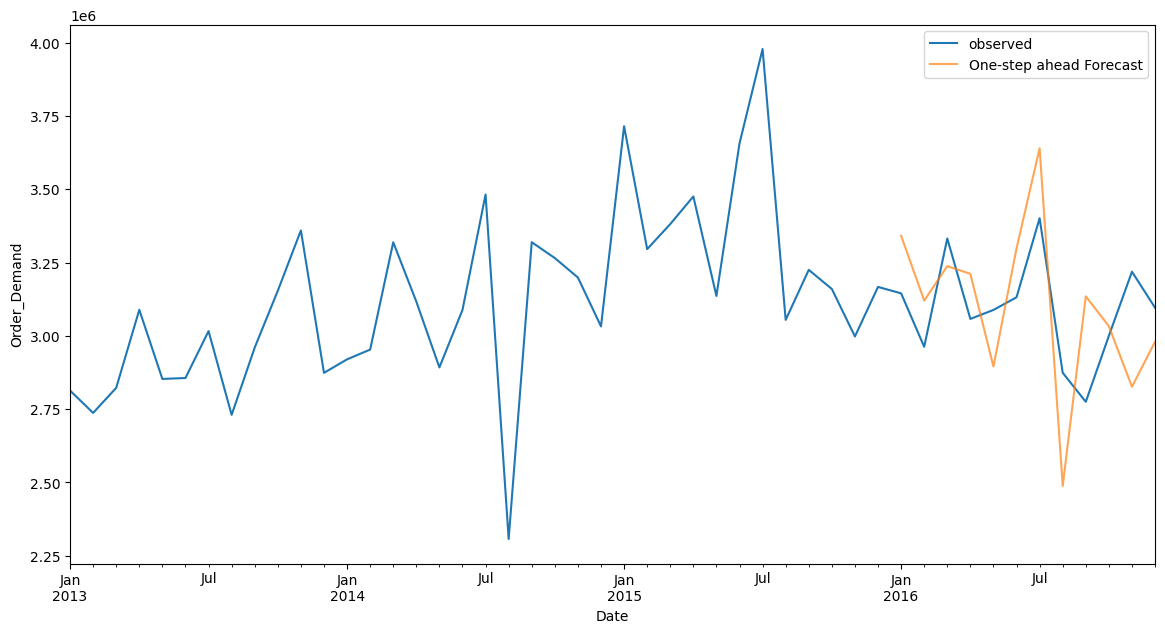

In [22]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()